In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


In [3]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%1000000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.1#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 207 ms, sys: 893 ms, total: 1.1 s
Wall time: 1.6 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [6]:
def compute_3dplot_from_seq_name(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    #plt.close()
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [10]:
def get_grid_protein(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']    
    global grid_protein
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]
    temp_protein =  protein_df.copy()
    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(temp_protein.RSA.values)
    y_total.append(temp_protein.ratio.values)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    
    step_x=0.1#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
#    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    return

In [13]:
def compile_umap_df(provided_seq_list):
    j=0
    for provided_seq in provided_seq_list:
        if j==0:
            get_grid_protein(provided_seq)
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'peptID',provided_seq)
            master_df = current_df.copy()
        else:
            get_grid_protein(provided_seq)
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'peptID',provided_seq)
            master_df = pd.concat([master_df,current_df]).copy()
        j+=1
    return master_df

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (10 sequences)

In [15]:
%%time
seq_w_diff_nu = ['Q86SE8_129_214','Q5JTH9_1043_1297','Q3T8J9_930_1609','P23497_144_598','O75822_218_258','Q9Y6Q9_366_1424',
                'A0A024RBG1_145_181','A1Z1Q3_243_425','A1L162_127_156','P0DME0_250_302']
master_df = compile_umap_df(seq_w_diff_nu).copy()

CPU times: user 1.13 s, sys: 133 ms, total: 1.26 s
Wall time: 1.27 s


In [86]:
master_df = master_df.reset_index(drop=True)
master_df

,peptID,box0,box1,box2,box3,box4,box5,box6,box7,box8,...,box90,box91,box92,box93,box94,box95,box96,box97,box98,box99
0,Q86SE8_129_214,55.0,44.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q5JTH9_1043_1297,78.0,44.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Q3T8J9_930_1609,56.0,47.0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P23497_144_598,78.0,41.0,13.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O75822_218_258,28.0,30.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Q9Y6Q9_366_1424,16.0,12.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,A0A024RBG1_145_181,14.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,A1Z1Q3_243_425,6.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
8,A1L162_127_156,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
9,P0DME0_250_302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
pd.DataFrame(proj_2d)

,0,1
0,5.777015,16.400379
1,4.556220,16.837049
2,5.253983,14.974957
3,4.021819,15.576277
4,6.488946,15.164732
5,7.486444,16.724329
6,8.159567,17.764853
7,8.482486,15.850457
8,9.671940,16.421288
9,9.458755,17.704889


/home/hshadman/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/hshadman/.local/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


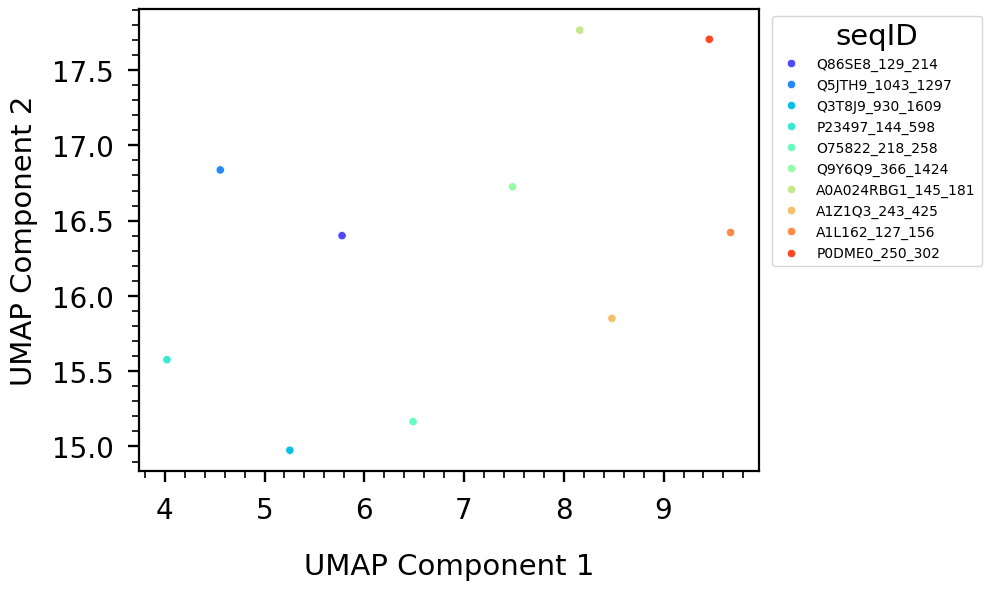

In [107]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

features = master_df[master_df.columns[master_df.columns.str.contains('box')]]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1],hue=master_df['peptID'],palette='rainbow')
#ax.scatter(proj_2d[:,0], proj_2d[:,1])
ax.legend(title='seqID', fontsize=10, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [22]:
%%time
all_seq_list = seq_name_dir_df['seq_name'].to_list()
master_df = compile_umap_df(all_seq_list).copy()

CPU times: user 45min 1s, sys: 5min 28s, total: 50min 29s
Wall time: 1h 4min 48s


In [23]:
master_df = master_df.reset_index(drop=True)
master_df

,peptID,box0,box1,box2,box3,box4,box5,box6,box7,box8,...,box90,box91,box92,box93,box94,box95,box96,box97,box98,box99
0,H0YL14_1_46,4.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,H0YL09_1_131,13.0,14.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0YKK7_1_89,8.0,11.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H0YKK7_135_164,4.0,12.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0YKK7_430_550,7.0,11.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,A3QJZ6_111_153,5.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28054,A3QJZ7_106_152,14.0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28055,A3KN83_1001_1044,5.0,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28056,A3KN83_1_250,7.0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
master_df.to_csv('all_seq_box_df.csv')

/home/hshadman/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_957609/3256836879.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1],palette='rainbow')


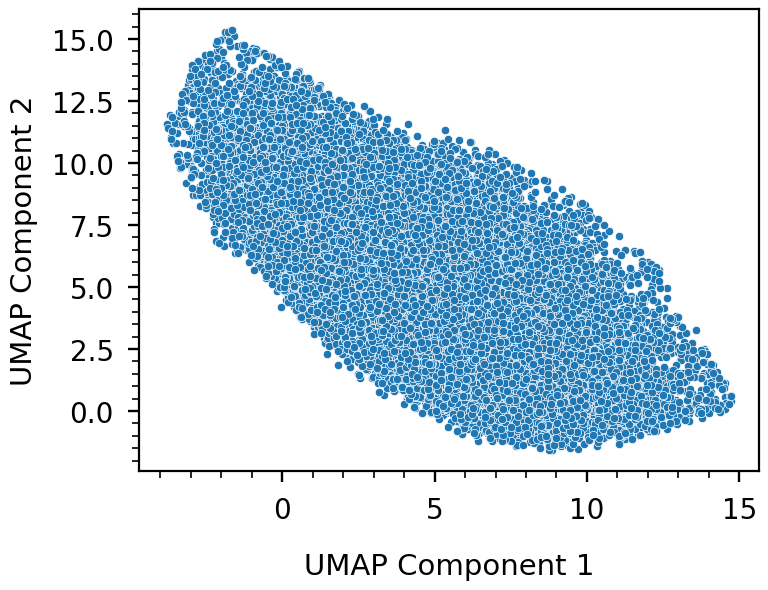

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

features = master_df[master_df.columns[master_df.columns.str.contains('box')]]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1],palette='rainbow')
#ax.scatter(proj_2d[:,0], proj_2d[:,1])
#ax.legend(title='seqID', fontsize=10, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

# function for pyconformap shape vs size

In [55]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 